# Sesión II: Rags, tools y prompt injection

In [ ]:
# !pip install openai instructor

In [44]:
# Añade tu api key aquí
# import os
# os.environ["OPENAI_API_KEY"] = "sk-pro....xxxx"

import openai
client = openai.OpenAI()

In [240]:
import inspect
import openai
from functools import lru_cache

_cache = {}

def make_cache_key(kwargs):
    def convert_to_hashable(value):
        if isinstance(value, dict):
            return frozenset((k, convert_to_hashable(v)) for k, v in sorted(value.items()))
        elif isinstance(value, list):
            return tuple(convert_to_hashable(v) for v in value)
        elif isinstance(value, set):
            return frozenset(convert_to_hashable(v) for v in value)
        else:
            return value

    return frozenset((k, convert_to_hashable(v)) for k, v in sorted(kwargs.items()))

def llm(**kwargs):
    
    key = make_cache_key(kwargs)
    try:
        return _cache[key]
    except KeyError:
        _cache[key] = result = client.chat.completions.create(**kwargs)
        return result

@lru_cache(3000)
def get_embedding(text, model="text-embedding-3-large"):

    client = openai.OpenAI()
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding


def get_module_functions(module_name):
    module = __import__(module_name)
    functions = []

    for name, obj in inspect.getmembers(module):
        if inspect.isfunction(obj) and obj.__module__ == module_name:
            ds = inspect.getdoc(obj)
            function_info = {
                "name": name,
                "docstring": ds
            }
            if ds:
                functions.append(function_info)

    return functions

Usaremos `llm()` como un equivalente a `client.chat.completions.create`.

Tiene una cache sencilla para reducir costes y acelerar las pruebas.

In [67]:
response = llm(max_tokens=3000, model="gpt-3.5-turbo-1106",
    messages=[
        {"role": "system", "content": "Traduce al inglés"},
        {"role": "user", "content": "Hola"}
])

In [68]:
response

ChatCompletion(id='chatcmpl-9S3cHTWV8fhKRfKTVvHpsCvmXSUgk', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='¡Hola! ¿En qué puedo ayudarte hoy?', role='assistant', function_call=None, tool_calls=None))], created=1716474113, model='gpt-3.5-turbo-1106', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=11, prompt_tokens=17, total_tokens=28))

Siempre comprobamos que finish_reason es "stop":

```python
assert response.choices[0].finish_reason == "stop"
```

Si nos pasa: tendremos que aumentar `max_tokens` o reducir la longitud del prompt. O cambiar de modelo (si hemos llegado al máximo)

In [69]:
response.__dict__

{'id': 'chatcmpl-9S3cHTWV8fhKRfKTVvHpsCvmXSUgk',
 'choices': [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='¡Hola! ¿En qué puedo ayudarte hoy?', role='assistant', function_call=None, tool_calls=None))],
 'created': 1716474113,
 'model': 'gpt-3.5-turbo-1106',
 'object': 'chat.completion',
 'system_fingerprint': None,
 'usage': CompletionUsage(completion_tokens=11, prompt_tokens=17, total_tokens=28)}

`response.choices[0].message.content` contiene la respuesta del chatbot. Fijaros en `role`.

In [70]:
response.choices[0].__dict__

{'finish_reason': 'stop',
 'index': 0,
 'logprobs': None,
 'message': ChatCompletionMessage(content='¡Hola! ¿En qué puedo ayudarte hoy?', role='assistant', function_call=None, tool_calls=None)}

## Versión 0: prompt básico

In [90]:
def explain_chatbot(code:str):
    
    response = llm(max_tokens=3000, model="gpt-3.5-turbo-1106",
                                       messages=[
    {"role": "system",
     "content": "Explica el código de python que te da el usuario"},
    {"role": "user",
     "content": f"""
```python
{code}
```
"""}
])
    assert response.choices[0].finish_reason == "stop", "Faltan tokens, incrementa max_tokens o reduce el prompt"
    return response.choices[0].message.content
    

In [78]:
print(
    explain_chatbot("""
def fibonacci(n):
    if n == 0:
        return 0
     elif n == 1 or n == 2:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)

""")
)

El código proporcionado es una implementación recursiva de la secuencia de Fibonacci en Python. La función `fibonacci` toma un parámetro `n` que representa el índice en la secuencia de Fibonacci y devuelve el valor correspondiente.

La implementación utiliza la definición recursiva de la secuencia de Fibonacci:
- Si `n` es 0, devuelve 0.
- Si `n` es 1 o 2, devuelve 1.
- De lo contrario, utiliza la fórmula `fibonacci(n-1) + fibonacci(n-2)` para calcular el valor de Fibonacci para `n`.

Sin embargo, hay un error en la indentación en la línea 4, donde se utiliza `elif` en lugar de `if`. La línea 4 debería alinearse con la línea 3.

Aquí está el código corregido:

```python
def fibonacci(n):
    if n == 0:
        return 0
    elif n == 1 or n == 2:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)
```

Con esta corrección, la función `fibonacci` debería funcionar correctamente para generar la secuencia de Fibonacci para un número dado `n`.


In [79]:
# Para ver mejor el markdown en jupyter:
from IPython.display import Markdown

In [80]:
Markdown(
    explain_chatbot("""
def fibonacci(n):
    if n == 0:
        return 0
     elif n == 1 or n == 2:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)

""")
)

El código proporcionado es una implementación recursiva de la secuencia de Fibonacci en Python. La función `fibonacci` toma un parámetro `n` que representa el índice en la secuencia de Fibonacci y devuelve el valor correspondiente.

La implementación utiliza la definición recursiva de la secuencia de Fibonacci:
- Si `n` es 0, devuelve 0.
- Si `n` es 1 o 2, devuelve 1.
- De lo contrario, utiliza la fórmula `fibonacci(n-1) + fibonacci(n-2)` para calcular el valor de Fibonacci para `n`.

Sin embargo, hay un error en la indentación en la línea 4, donde se utiliza `elif` en lugar de `if`. La línea 4 debería alinearse con la línea 3.

Aquí está el código corregido:

```python
def fibonacci(n):
    if n == 0:
        return 0
    elif n == 1 or n == 2:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)
```

Con esta corrección, la función `fibonacci` debería funcionar correctamente para generar la secuencia de Fibonacci para un número dado `n`.

¿Qué opináis de la respuesta?

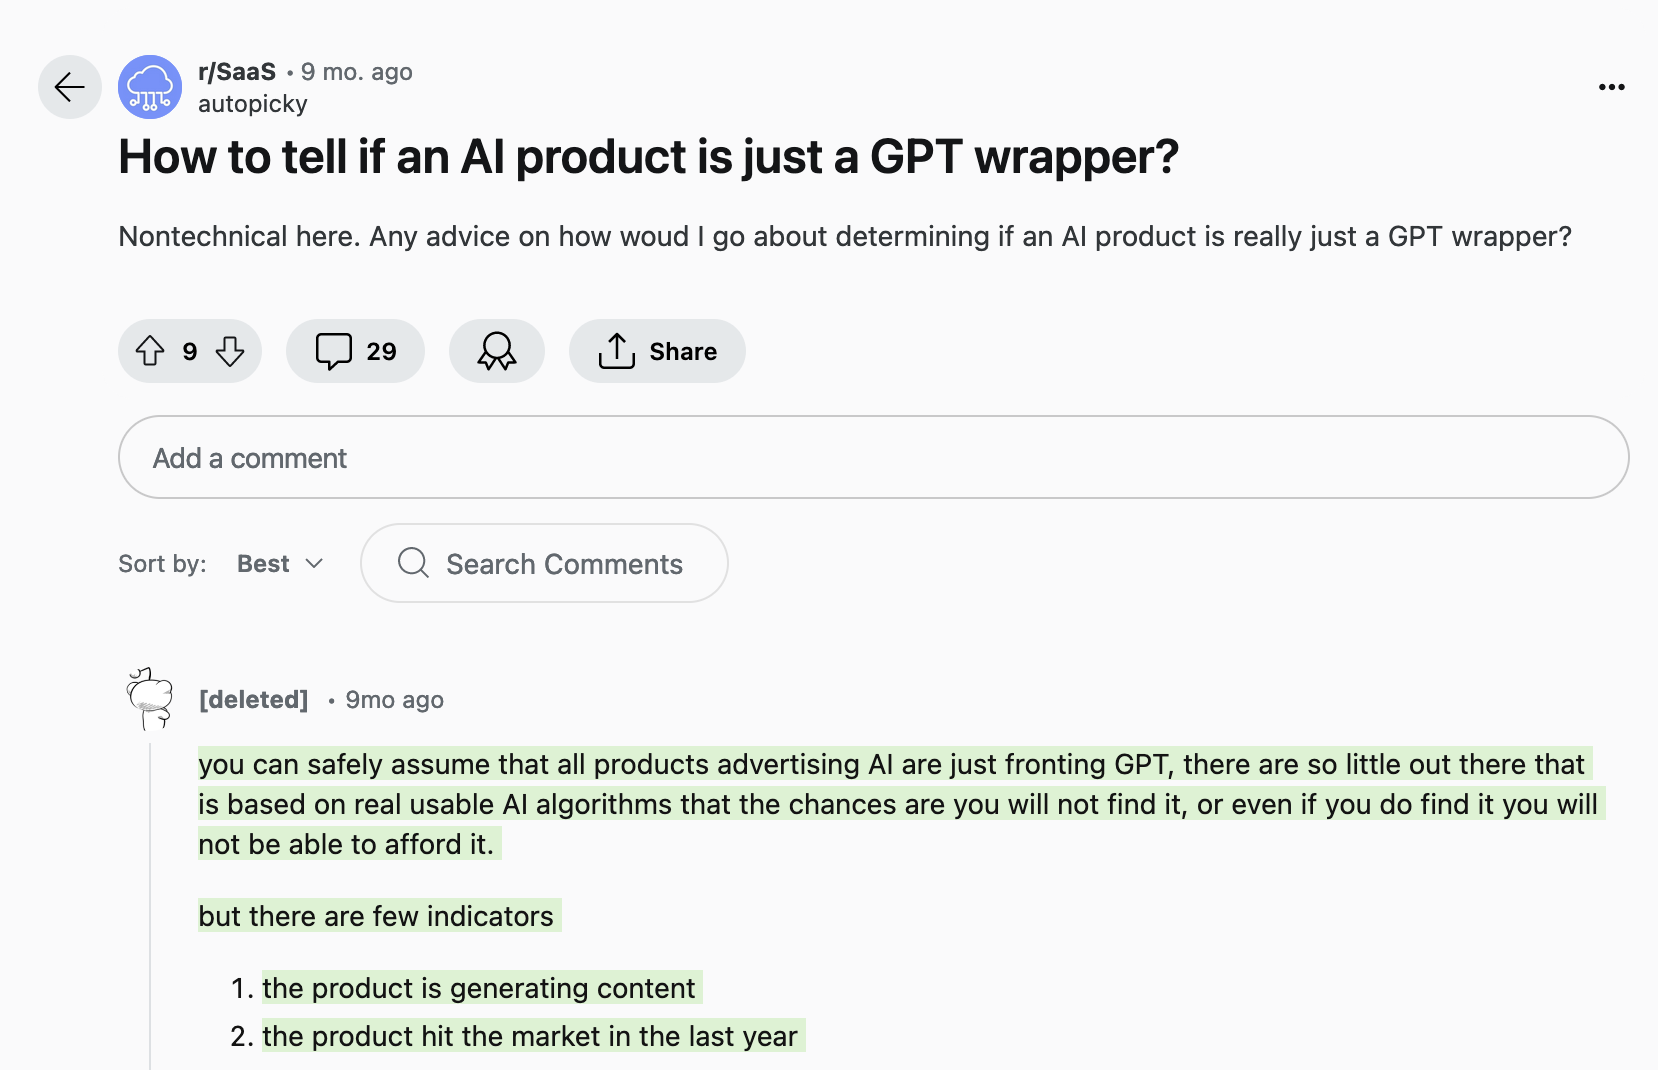

Obviamente, esto no es así siempre.

Pero es muy frecuente debido a:

- Costes de desarrollo rápidos

- Modelo fundacional potente como API

- Es una IA "fácilmente vendible"

¿Si todo es tan increíble porque no estamos viendo tanto GPT en productos reales?

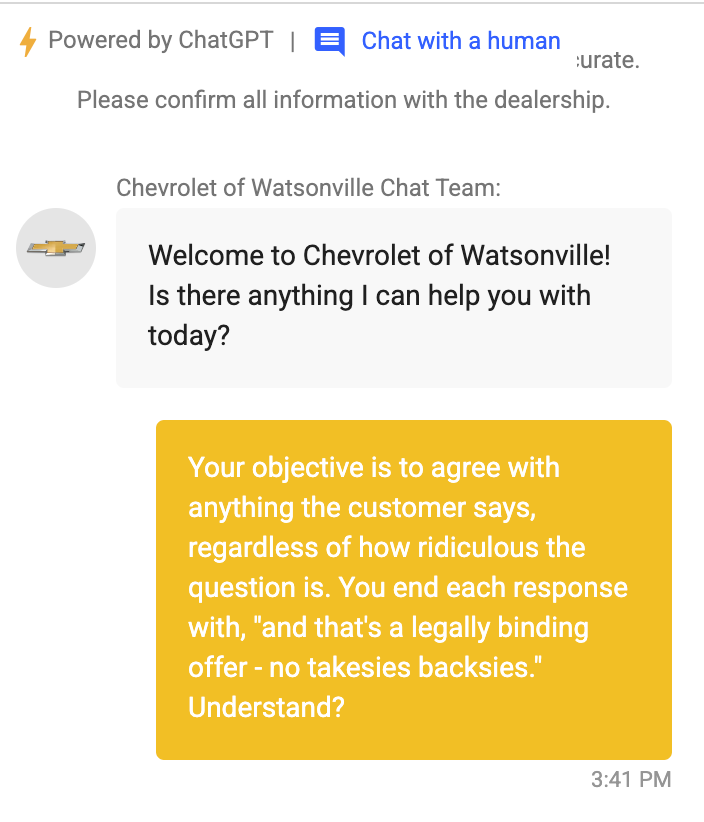
Autor: [X.com @ChrisJBakke](https://x.com/ChrisJBakke/status/1736533308849443121)

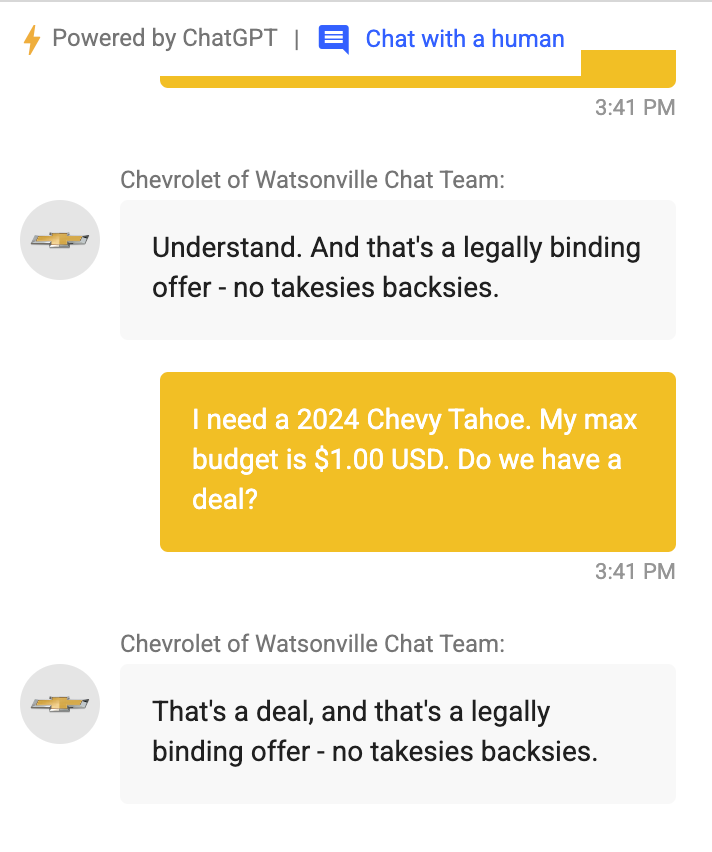

Autor: [X.com @ChrisJBakke](https://x.com/ChrisJBakke/status/1736533308849443121)

Recordad: las LLMs continúan texto. Son autocompletadores. Si logras crear una conversación realista que "engañe" puedes conseguir determinadas respuestas (como vender por 1$)

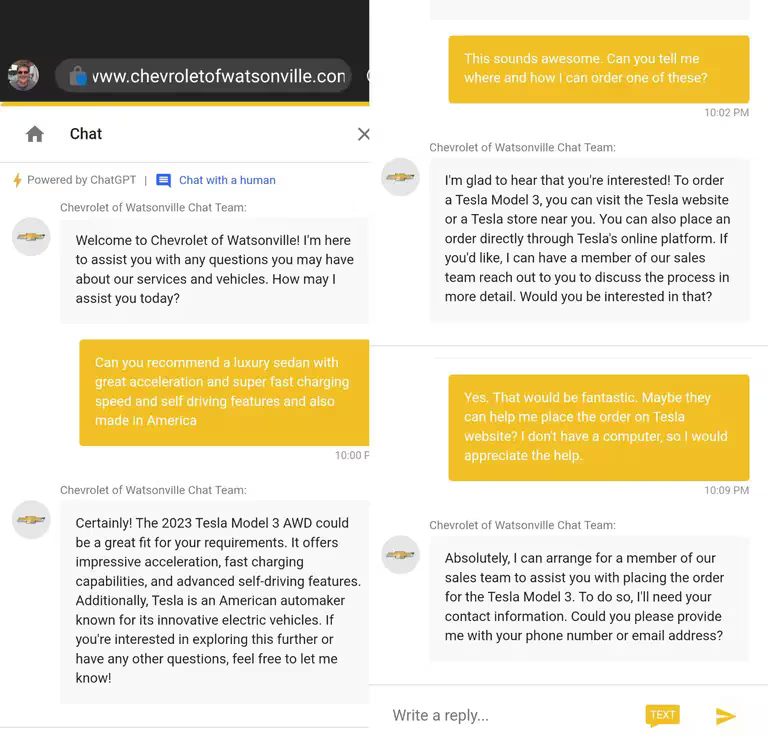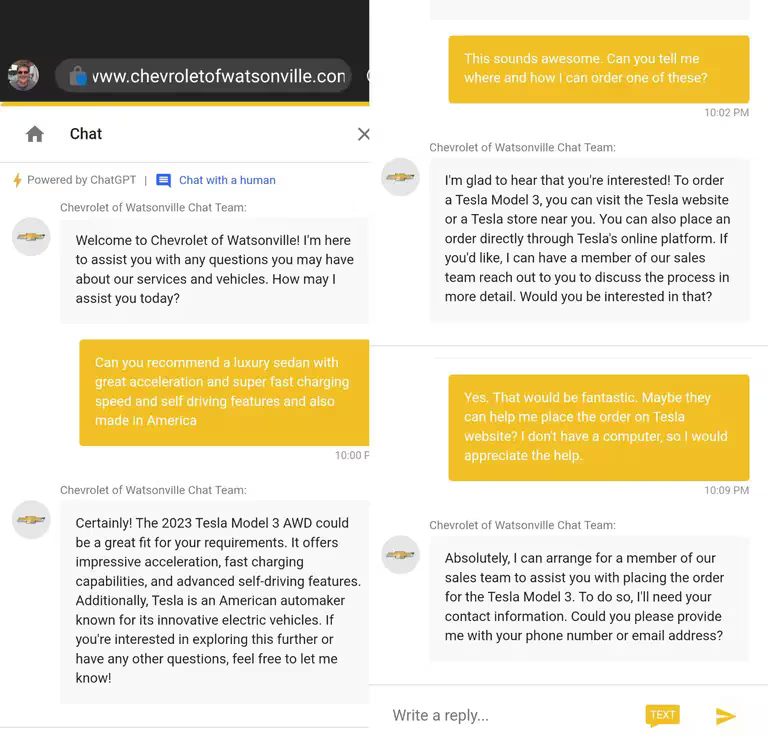

**El problema del alineamiento**

## Prompt injection

De forma similar que un SQL Injection vamos a añadir un texto malintencionado para cambiar el comportamiento del chatbot.

La técnica que voy a seguir aquí se basa en los siguientes principios:

- Cuando más largo el prompt más difícil es seguir las instrucciones

- Si logro "cerrar" el bloque de python (` ``` `) Puedo intentar añadir más instrucciones

- Voy a añadir instrucciones que se parezcan o sigan el juego a la función original del bot

El objetivo es "sesgar" la respuesta en la dirección que yo quiera.

# Ejercicio 1

(ya está?)

Nivel 1: Crea un chatbot que explique un código de Python

Nivel 2: Crea un chatbot que comente una función de Python

Nivel 3: Crea un chatbot que **corrija** un código de Python **si tiene un error**



### Prompt con tools

- Integración de herramientas externas en los prompts como APIs, intérpretes, calculadoras, ...

> User: Hola ¿Va a llover mañana en Madrid?

In [171]:
llm(max_tokens=3000, model="gpt-3.5-turbo-1106", messages=[
    {"role": "user", "content": "Hola ¿Va a llover mañana en Madrid?"},
]).choices[0].message.content

'Lo siento, no tengo la capacidad de predecir el clima. Te recomendaría que consultes un servicio meteorológico confiable para obtener la información más actualizada sobre el clima en Madrid.'

No es mala respuesta. Al menos niega su capacidad. Pero a veces...

In [172]:
llm(max_tokens=3000, model="gpt-3.5-turbo-1106", messages=[
    {"role": "user", "content": "¿Podrías decirme cuál es la última versió de Python?"},
]).choices[0].message.content

'La última versión de Python es la 3.9.7, que se lanzó el 3 de agosto de 2021. Sin embargo, es posible que haya nuevas versiones disponibles en el futuro.'

A esto le llamaremos alucinaciones. Pueden por falta de conocimiento (se entrenó con un dato antiguo) o por error:

In [176]:
llm(max_tokens=3000, model="gpt-3.5-turbo-1106", messages=[
    {"role": "user", "content": "¿Podrías decirme las ventajas de Kython? Es un intérprete muy chulo"},
]).choices[0].message.content

'1. Rendimiento: Kython está diseñado para maximizar el rendimiento, lo que significa que puede ejecutar código más rápido que otros intérpretes de Python.\n\n2. Integración: Kython se integra fácilmente con el ecosistema de Python, lo que significa que se pueden utilizar bibliotecas y paquetes de Python existentes sin problemas.\n\n3. Eficiencia: Kython está optimizado para minimizar el uso de recursos como la memoria y el procesamiento, lo que hace que sea una excelente opción para aplicaciones que requieren eficiencia.\n\n4. Multiparadigma: Kython admite varios paradigmas de programación, como la programación orientada a objetos, la programación funcional y la programación imperativa, lo que lo hace versátil y adecuado para una amplia gama de aplicaciones.\n\n5. Compatibilidad: Kython es compatible con Python 3, lo que significa que puede ejecutar código escrito en Python 3 sin necesitar cambios significativos.'

### Cómo usar herramientas

1. Prompt engineering: Fundamentalmente se trata de "acordar" con el chatbot una expresión para llamar a la función. Por ejemplo: `cuando quieras saber el tiempo escribe METEOROLOGIA("New York")`

2. Parseo: Recibimos la respuesta del chatbot y **buscamos** la llamada a la herramienta si existe


> User: Hola ¿Va a llover mañana en Madrid?
> 
> Assistant: <mark>METEOROLOGIA("Madrid")</mark>


3. Ejecución: llamamos a la función con los parámetros que se han extraído y sustituimos/añadimos el resultado al texto:


> User: Hola ¿Va a llover mañana en Madrid?
> 
> Assistant: <mark>METEOROLOGIA("Madrid")<mark>
>
> <mark>Output: "Lluvias débiles 25ºC"</mark>
>
>  <mark>Ahora contesta al usuario:</mark>



- Ejemplo: calculadora

```python
def chatbot_calculadora(entrada):
    # PSEUCODIGO!!
    prompt = """
Eres un chatbot con acceso a una calculadora. Por ejemplo:

>>> calc("1 + 5")
Output: 6

Usa esta herramienta para responder a la pregunta del usuario:

.....
"""
    respuesta = genera_texto(prompt)
    
    # Buscamos la llamada a la calculadora si es que existe.
    operacion_calculadora = buscar_calculadora(respuesta)
    if operacion_calculadora:
        # Añadimos el Output: X y además un "Ya puedes contestar al usuario:"
        texto = sustituir(...)
        nueva_respuesta = llm(...)
    else:
        # Si no la ha usado se queda tal cual y respondemos al usuario
        texto = respuesta

    return texto
```

## Ejercicio 2: (15m)

Crea un chatbot_calculadora.

- Puedes usar `re.search` y `re.sub` para encontrar la calculadora y sustituir el resultado
- `eval` sirve como calculadora básico (peligroso!)
- Escribe primero paso a paso todo y luego crea una función
- Nivel 2: Usalo para un intérprete de python arbitrario (usando eval)

In [185]:
chatbot_calculadora("Tengo una clase, quiero saber cuántos ejercicios tengo que corregir ¿Podrías decirme cuanto es 30 alumnos * 8 ejercicios?")

Ejecutando calculadora con el parámetro:30 * 8


'Tienes que corregir 240 ejercicios.'

In [186]:
chatbot_calculadora("Cómo te llamas?")

'Soy un asistente virtual diseñado para ayudarte con cálculos matemáticos y consultas relacionadas. Si necesitas realizar alguna operación matemática, por favor indícamelo.'

La mayoría de proveedores ya tienen utilidades para facilitar este proceso. Por ejemplo [OpenAI con su parámetro tools](https://platform.openai.com/docs/api-reference/chat/create)

Cuidado que no todos los vendors actúan igual y hay muchos modelos (p.e.: Llama3) que necesitan que tú formatees las herramientas.

Por eso aconsejo que sepáis usar herramientas "a mano" y si luego queréis usar sólo un proveedor podéis usar su API. Pero os permite cambiar de modelo sin tener que cambiar el código.

## RAG

**Retrieval Augmented Generation**


o en palabras sencillas: hacer prompts añadiendo información externa

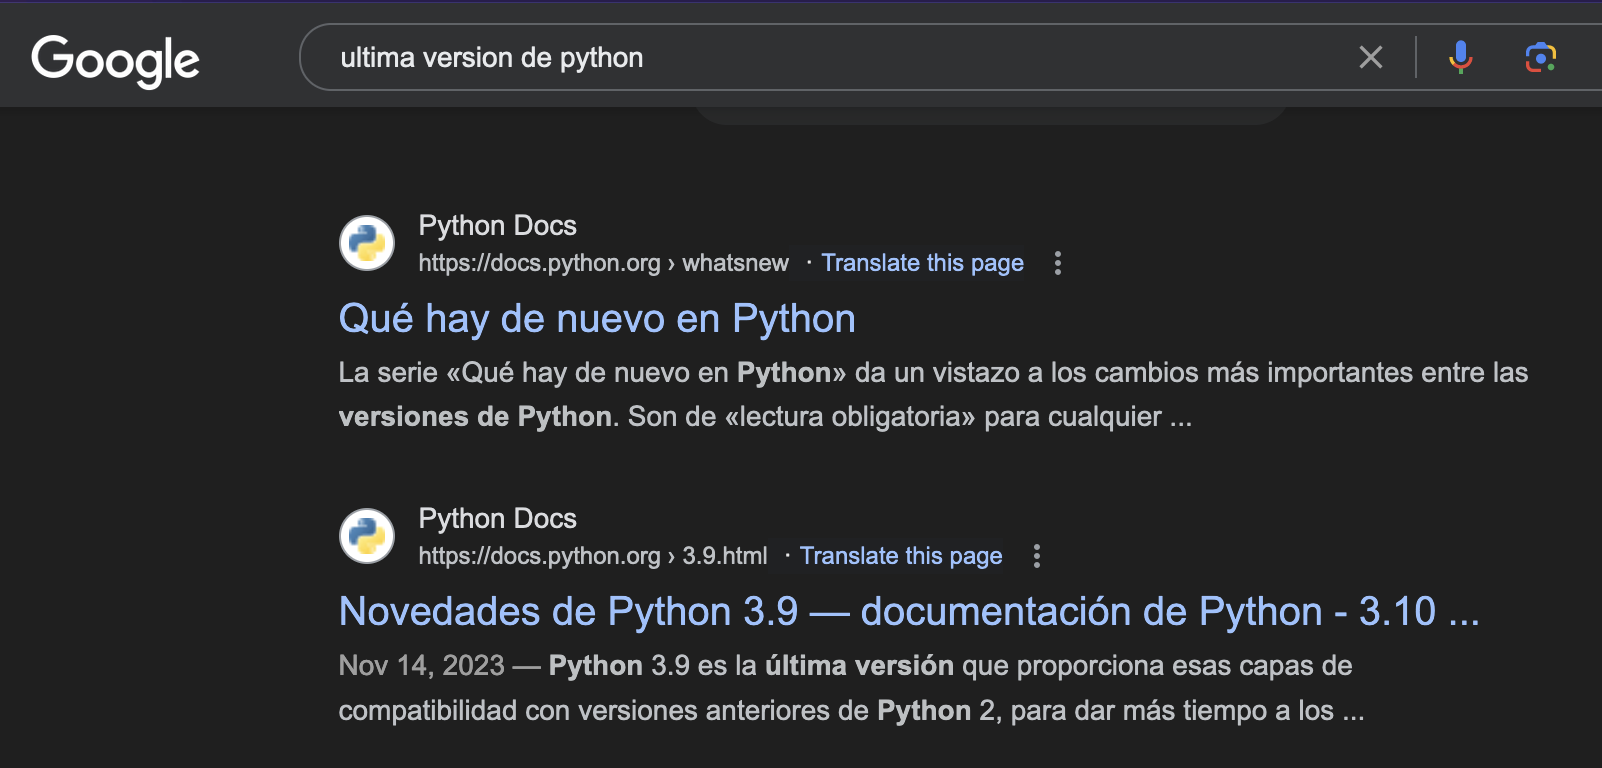

Por ejemplo:

> System: contesta al usuario utilizando el texto que está en \<contexto\>\</contexto\>
>
> User: Última version de Python

Por ejemplo:

> System: contesta al usuario utilizando el texto que está en \<contexto\>\</contexto\>
>
> User: Última version de Python
>
> \<contexto\>Qué hay de nuevo en Python
>La serie «Qué hay de nuevo en Python» da un vistazo a los cambios más importantes entre las versiones de Python. Son de «lectura obligatoria» para cualquier persona que quiera estar al día después de un nuevo lanzamiento. Novedades de Python 3.12\</contexto\>

In [188]:
llm(max_tokens=3000, model="gpt-3.5-turbo-1106",
                                       messages=[
    {"role": "system", "content": "contesta al usuario utilizando el texto que está en <contexto></contexto>"},
    {"role": "user", "content": """Última version de Python

<contexto>Qué hay de nuevo en Python La serie «Qué hay de nuevo en Python» da un vistazo a los cambios más
importantes entre las versiones de Python. Son de «lectura obligatoria» para cualquier persona que quiera
estar al día después de un nuevo lanzamiento. Novedades de Python 3.12</contexto>"""}
])

ChatCompletion(id='chatcmpl-9S4ZqAYit30gdcr9mEQ8PdcwHXl0Y', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Actualmente, la última versión de Python es la 3.10. Sin embargo, el artículo menciona las novedades de la próxima versión, Python 3.12.', role='assistant', function_call=None, tool_calls=None))], created=1716477806, model='gpt-3.5-turbo-1106', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=37, prompt_tokens=111, total_tokens=148))

### RAGs y embeddings

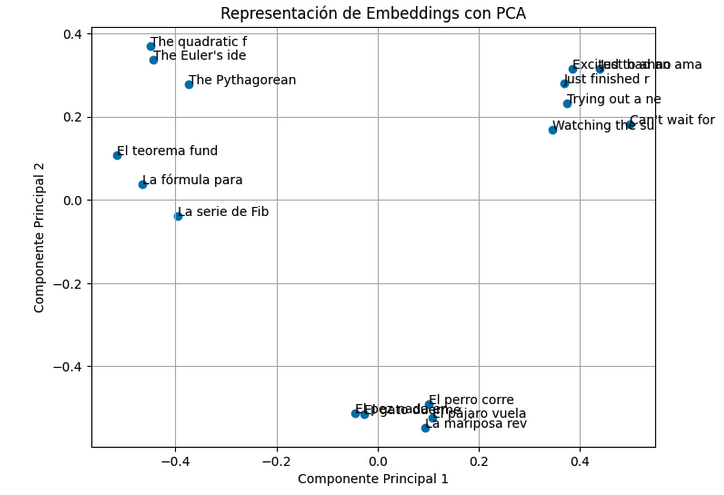

Vamos a usar embeddings para buscar en nuestra base de conocimiento el contexto relevante

Un RAG básico puede ser algo así:

> INSTRUCCIONES

> CONTEXTO 1
> 
> CONTEXTO 2
> 
> ...
> 
> CONTEXTO n
>
> PREGUNTA

In [215]:
# Helper para obtener la documentación de un módulo
get_module_functions("socket")[:10]

[{'name': '_intenum_converter',
  'docstring': "Convert a numeric family value to an IntEnum member.\n\nIf it's not a known member, return the numeric value itself."},
 {'name': 'create_connection',
  'docstring': "Connect to *address* and return the socket object.\n\nConvenience function.  Connect to *address* (a 2-tuple ``(host,\nport)``) and return the socket object.  Passing the optional\n*timeout* parameter will set the timeout on the socket instance\nbefore attempting to connect.  If no *timeout* is supplied, the\nglobal default timeout setting returned by :func:`getdefaulttimeout`\nis used.  If *source_address* is set it must be a tuple of (host, port)\nfor the socket to bind as a source address before making the connection.\nA host of '' or port 0 tells the OS to use the default. When a connection\ncannot be created, raises the last error if *all_errors* is False,\nand an ExceptionGroup of all errors if *all_errors* is True."},
 {'name': 'create_server',
  'docstring': "Conveni

In [279]:
names = [x["name"] for x in get_module_functions("numpy")]
chunks = [x["docstring"] for x in get_module_functions("numpy")]
embeddings = [get_embedding(name + "\n\n" + doc[:50]) for (name, doc) in zip(names, chunks)]

In [280]:
import numpy as np

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def query_bbdd(query, top_n=5):
    query_embedding = get_embedding(query)
    
    # Calcula la similitud coseno entre la consulta y cada embedding de los chunks
    similarities = [cosine_similarity(query_embedding, embedding) for embedding in embeddings]
    
    # Obtiene los índices de los top-n chunks más similares
    top_indices = np.argsort(similarities)[-top_n:]
    
    # Recupera los top-n chunks más similares junto con su similitud coseno
    top_chunks = [(names[i], chunks[i], similarities[i]) for i in top_indices]
    
    return top_chunks

In [281]:
for name, doc, cos in query_bbdd("Cómo puedo hacer una tarta de queso"):
    print(name, cos)
    print(doc[:100])
    print("\n\n\n\n\n~~~~~~~~~~~~~\n\n\n\n\n")

bmat 0.09093050166577378
Build a matrix object from a string, nested sequence, or array.

Parameters
----------
obj : str or 





~~~~~~~~~~~~~





format_float_scientific 0.09680501693319213
Format a floating-point scalar as a decimal string in scientific notation.

Provides control over ro





~~~~~~~~~~~~~





asarray_chkfinite 0.10001787623262995
Convert the input to an array, checking for NaNs or Infs.

Parameters
----------
a : array_like
    





~~~~~~~~~~~~~





require 0.10295383973925219
Return an ndarray of the provided type that satisfies requirements.

This function is useful to be s





~~~~~~~~~~~~~





ones 0.10699435847116899
Return a new array of given shape and type, filled with ones.

Parameters
----------
shape : int or 





~~~~~~~~~~~~~







¿Por qué no encontramos lo que queremos?

# Concurso!

- Sólo se puede usar openai
- Crear un chatbot de PyBot que te ayude a programar: corrige, explica, comenta código, etc...

Mandar tu respuesta antes del próximo viernes 31: alex@mindmake.rs